# Exploratory Data Analysis

KKBox music streaming subscription churn dataset for Kaggle Comeptition. Exploring dataset structure, data quality, and distributions before building retention and churn analyses.

In [3]:
from google.cloud import bigquery
from dotenv import load_dotenv
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import os

warnings.filterwarnings('ignore')
load_dotenv()

GCP_PROJECT = os.environ.get("GCP_PROJECT")
client = bigquery.Client(project=GCP_PROJECT)

def run_query(sql):
    return client.query(sql).to_dataframe()

## Table Overview

In [2]:
# Table schemas
for table in ['train', 'members', 'transactions', 'user_logs']:
    print(f"\n{table}")
    print("-" * 40)
    table_ref = client.get_table(f'kkbox.{table}')
    for field in table_ref.schema:
        print(f"  {field.name}: {field.field_type}")


train
----------------------------------------
  msno: STRING
  is_churn: INTEGER

members
----------------------------------------
  msno: STRING
  city: INTEGER
  bd: INTEGER
  gender: STRING
  registered_via: INTEGER
  registration_init_time: INTEGER

transactions
----------------------------------------
  msno: STRING
  payment_method_id: INTEGER
  payment_plan_days: INTEGER
  plan_list_price: INTEGER
  actual_amount_paid: INTEGER
  is_auto_renew: INTEGER
  transaction_date: INTEGER
  membership_expire_date: INTEGER
  is_cancel: INTEGER

user_logs
----------------------------------------
  msno: STRING
  date: INTEGER
  num_25: INTEGER
  num_50: INTEGER
  num_75: INTEGER
  num_985: INTEGER
  num_100: INTEGER
  num_unq: INTEGER
  total_secs: FLOAT


Four tables joined by `msno` (user ID). Dates stored as integers (likely YYYYMMDD format). The user_logs fields `num_25`, `num_50`, `num_75`, `num_985`, `num_100` have unclear meaning from names alone.

## Churn Definition

The Kaggle competition included a `WSDMChurnLabeller.scala` file documenting how the target variable was generated.

In [3]:
with open('../data/WSDMChurnLabeller.scala', 'r') as f:
    print(f.read())

import java.time.{LocalDate}
import java.time.format.DateTimeFormatter
import java.time.temporal.ChronoUnit

import org.apache.spark.sql.{Row, SparkSession}
import org.apache.spark.sql.functions._

import scala.collection.mutable

object WSDMChurnLabeller {
  def main(args: Array[String]) : Unit ={
    val spark = SparkSession
      .builder()
      .master("local")
      .getOrCreate()

    val data = spark
      .read
      .option("header", value = true)
      .csv("/Users/ardenchiu/wsdm_fix/wsdm_transactions_20170331.csv")

    val historyCutoff = "20170131"

    val historyData = data.filter(col("transaction_date")>="20170101" and col("transaction_date")<=lit(historyCutoff))
    val futureData = data.filter(col("transaction_date") > lit(historyCutoff))

    val calculateLastdayUDF = udf(calculateLastday _)
    val userExpire = historyData
      .groupBy("msno")
      .agg(
        calculateLastdayUDF(
          collect_list(
            struct(
              col("payment_method_id

The churn logic:

1. Users are included in the prediction set if their membership expired between Feb 1-28, 2017
2. A user is labeled `is_churn = 1` if:
   - They had no transaction activity after Jan 31, 2017, OR
   - They renewed but 30 or more days after their expiration date
3. A user is labeled `is_churn = 0` if they renewed in fewer than 30 days

The prediction task is: given user behavior through Jan 2017, predict whether they will fail to renew within 30 days of their Feb 2017 membership expiration.

## Churn Distribution

In [4]:
churn_df = run_query("""
SELECT 
    is_churn,
    COUNT(*) as user_count,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER(), 1) as pct
FROM kkbox.train
GROUP BY is_churn
ORDER BY is_churn
""")
churn_df

,is_churn,user_count,pct
0,0,883630,91.0
1,1,87330,9.0


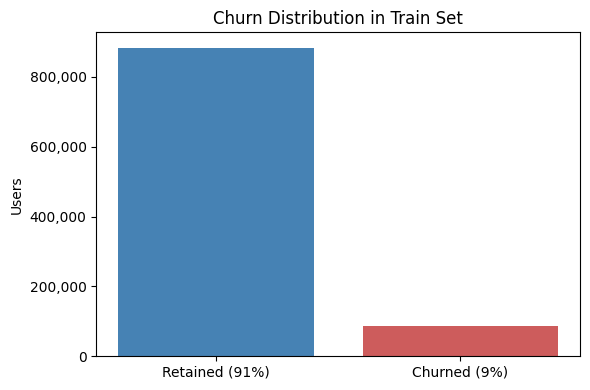

In [5]:
# Churn distribution bar graph
retained = churn_df[churn_df['is_churn'] == 0].iloc[0]
churned = churn_df[churn_df['is_churn'] == 1].iloc[0]

churn_counts = [retained['user_count'], churned['user_count']]
labels = [f"Retained ({retained['pct']:.0f}%)", f"Churned ({churned['pct']:.0f}%)"]

plt.figure(figsize=(6, 4))
plt.bar(labels, churn_counts, color=['steelblue', 'indianred'])
plt.ylabel('Users')
plt.title('Churn Distribution in Train Set')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.tight_layout()
plt.show()

9% churn rate (87,330 of 970,960 users). This is imbalanced, which will affect model evaluation. Accuracy alone would be misleading since predicting "no churn" for everyone achieves 91% accuracy.

## Members Table

In [ ]:
# Member records
run_query("""
SELECT
    COUNT(*) as total_members,
    COUNT(DISTINCT msno) as unique_members,
    (SELECT COUNT(*) FROM kkbox.train) as train_users,
    ROUND((SELECT COUNT(*) FROM kkbox.train) * 100.0 / COUNT(*), 1) as pct_in_train
FROM kkbox.members
""")

,total_members,unique_members,train_users,pct_in_train
0,6769473,6769473,970960,14.3


6.77M unique members, no duplicates. The train table has 970,960 users, so only about 14% of all members are in the prediction set. This tracks since the churn definition only includes users whose memberships expired in Feb 2017.

In [9]:
# How many train users have member records?
run_query("""
SELECT
    COUNT(*) as train_users,
    COUNT(m.msno) as have_member_record,
    ROUND(COUNT(m.msno) * 100.0 / COUNT(*), 1) as pct_with_record
FROM kkbox.train t
LEFT JOIN kkbox.members m ON t.msno = m.msno
""")

,train_users,have_member_record,pct_with_record
0,970960,860967,88.7


860,967 of 970,960 train users (89%) have member records. About 110,000 users in the prediction set have no demographic data available.

In [8]:
# Member demographics - gender
run_query("""
SELECT 
    gender,
    COUNT(*) as user_count,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER(), 1) as pct
FROM kkbox.members
GROUP BY gender
ORDER BY user_count DESC
""")

,gender,user_count,pct
0,None,4429505,65.4
1,male,1195355,17.7
2,female,1144613,16.9


65% of members have no gender recorded. Among those with gender data, the split is roughly even (male 17.7%, female 16.9%). The high missing rate means gender may not be a reliable feature.

In [7]:
# Member demographics - age (bd field)
run_query("""
SELECT 
    MIN(bd) as min_age,
    MAX(bd) as max_age,
    ROUND(AVG(bd), 1) as avg_age
FROM kkbox.members
""")

,min_age,max_age,avg_age
0,-7168,2016,9.8


Age data has quality issues. Values range from -7168 to 2016, indicating the field stores calculated age (reference_year - birth_year) with many invalid inputs. The reference year was likely 2016 when the members table was generated.

In [10]:
# Age distribution 
run_query("""
SELECT 
    CASE 
        WHEN bd <= 0 THEN '0 or negative'
        WHEN bd BETWEEN 1 AND 17 THEN '1-17'
        WHEN bd BETWEEN 18 AND 65 THEN '18-65'
        WHEN bd BETWEEN 66 AND 100 THEN '66-100'
        ELSE 'over 100'
    END as age_range,
    COUNT(*) as user_count,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER(), 1) as pct
FROM kkbox.members
GROUP BY age_range
ORDER BY pct DESC
""")

,age_range,user_count,pct
0,0 or negative,4540489,67.1
1,18-65,2061255,30.4
2,1-17,149257,2.2
3,66-100,13095,0.2
4,over 100,5377,0.1


67% of age values are 0 or negative, indicating invalid input data. Realistic upper and lower bounds of the technically valid age range needs to be explored as well.

In [11]:
# Age distribution for positive values - both ends
run_query("""
SELECT 
    APPROX_QUANTILES(bd, 100)[OFFSET(1)] as p1,
    APPROX_QUANTILES(bd, 100)[OFFSET(5)] as p5,
    APPROX_QUANTILES(bd, 100)[OFFSET(10)] as p10,
    APPROX_QUANTILES(bd, 100)[OFFSET(50)] as p50,
    APPROX_QUANTILES(bd, 100)[OFFSET(90)] as p90,
    APPROX_QUANTILES(bd, 100)[OFFSET(95)] as p95,
    APPROX_QUANTILES(bd, 100)[OFFSET(99)] as p99
FROM kkbox.members
WHERE bd > 0 AND bd <= 100
""")

,p1,p5,p10,p50,p90,p95,p99
0,15,17,18,27,44,50,61


Among ages 1-100, the distribution looks plausible: median 27, with 99% between 15 and 61. The 1st percentile at 15 indicates ages below 15 are rare.

In [31]:
# Do young users have transaction records?
run_query("""
SELECT 
    CASE 
        WHEN m.bd BETWEEN 1 AND 5 THEN '1-5'
        WHEN m.bd BETWEEN 6 AND 10 THEN '6-10'
        WHEN m.bd BETWEEN 11 AND 15 THEN '11-15'
        WHEN m.bd BETWEEN 16 AND 20 THEN '16-20'
    END as age_group,
    COUNT(DISTINCT m.msno) as members,
    COUNT(DISTINCT tr.msno) as with_transactions,
    ROUND(COUNT(DISTINCT tr.msno) * 100.0 / COUNT(DISTINCT m.msno), 1) as pct_with_transactions
FROM kkbox.members m
LEFT JOIN kkbox.transactions tr ON m.msno = tr.msno
WHERE m.bd BETWEEN 1 AND 20
GROUP BY age_group
ORDER BY MIN(m.bd)
""")

,age_group,members,with_transactions,pct_with_transactions
0,1-5,387,115,29.7
1,6-10,609,95,15.6
2,11-15,23372,1813,7.8
3,16-20,417374,59569,14.3


Ages below 6 are implausible for independent music streaming use and independent transactions. Given the poor validity of age data, it is uncertain which of the more plausible younger age ranges are valid. To be safe, age 13 will be treated as the minimum valid age.

In [13]:
# Registration channel
run_query("""
SELECT 
    registered_via,
    COUNT(*) as user_count,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER(), 1) as pct
FROM kkbox.members
GROUP BY registered_via
ORDER BY user_count DESC
""")

,registered_via,user_count,pct
0,4,2793213,41.3
1,3,1643208,24.3
2,9,1482863,21.9
3,7,805895,11.9
4,11,25047,0.4
5,13,5455,0.1
6,8,3982,0.1
7,5,3115,0.0
8,17,1494,0.0
9,2,1452,0.0


Registration channels are numeric codes without labels. Four channels dominate: 4 (41.3%), 3 (24.3%), 9 (21.9%), and 7 (11.9%) account for 99.4% of users. One record has -1, likely invalid. The codes can be used as categorical features without knowing their meaning.

## Transactions Table

In [14]:
# Total transactions and unique users
run_query("""
SELECT
    COUNT(*) as total_transactions,
    COUNT(DISTINCT msno) as unique_users,
    ROUND(COUNT(*) * 1.0 / COUNT(DISTINCT msno), 1) as avg_transactions_per_user
FROM kkbox.transactions
""")

,total_transactions,unique_users,avg_transactions_per_user
0,1431009,1197050,1.2


1.43M transactions from 1.2M unique users, averaging about 1.2 transactions per user. Many users have only one transaction in this dataset.

In [15]:
# Transaction date range
run_query("""
SELECT 
    MIN(transaction_date) as earliest,
    MAX(transaction_date) as latest
FROM kkbox.transactions
""")

,earliest,latest
0,20150101,20170331


Transactions span Jan 2015 to Mar 2017 (27 months). This aligns with the churn labeling logic: history through Jan 2017 is used for features, and Feb-Mar 2017 activity determines the churn label.

In [16]:
# Registration year distribution
reg_years_df = run_query("""
SELECT 
    EXTRACT(YEAR FROM PARSE_DATE('%Y%m%d', CAST(registration_init_time AS STRING))) as reg_year,
    COUNT(*) as users
FROM kkbox.members
WHERE msno IN (SELECT msno FROM kkbox.train)
GROUP BY reg_year
ORDER BY reg_year
""")
reg_years_df

,reg_year,users
0,2004,8330
1,2005,15616
2,2006,18048
3,2007,26158
4,2008,17685
5,2009,15731
6,2010,38640
7,2011,60698
8,2012,74495
9,2013,113444


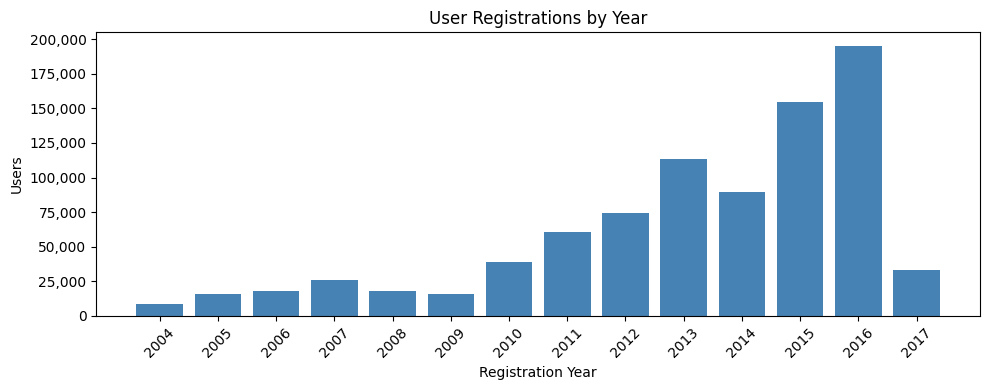

In [17]:
# Registration year distribution
plt.figure(figsize=(10, 4))
plt.bar(reg_years_df['reg_year'].astype(str), reg_years_df['users'], color='steelblue')
plt.xlabel('Registration Year')
plt.ylabel('Users')
plt.title('User Registrations by Year')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Registration dates span 2004 to 2017. Growth accelerated from 2010 onward, with 2015 and 2016 contributing the most users (154K and 195K). The 33K users registered in 2017 includes both January (valid) and potentially later months (invalid for tenure calculation).

In [18]:
# Check for registration dates after prediction cutoff (Jan 31, 2017)
run_query("""
SELECT 
    COUNT(*) as users_registered_after_cutoff
FROM kkbox.members
WHERE registration_init_time > 20170131
  AND msno IN (SELECT msno FROM kkbox.train)
""")

,users_registered_after_cutoff
0,18152


18,152 users (1.9%) have registration dates after the prediction cutoff (Jan 31, 2017). These will produce negative tenure values. For the prediction model, tenure for these users will be set to NULL.

In [2]:
# Users with listening activity before their registration date
run_query("""
SELECT 
    COUNT(DISTINCT ul.msno) as users_with_early_activity,
    (SELECT COUNT(DISTINCT msno) FROM kkbox.train) as total_train_users,
    ROUND(COUNT(DISTINCT ul.msno) * 100.0 / (SELECT COUNT(DISTINCT msno) FROM kkbox.train), 2) as pct
FROM kkbox.user_logs ul
JOIN kkbox.members m ON ul.msno = m.msno
WHERE ul.msno IN (SELECT msno FROM kkbox.train)
  AND ul.date < m.registration_init_time
""")

,users_with_early_activity,total_train_users,pct
0,5,970960,0.0


5 users have listening activity before their recorded registration date. These users should be excluded from cohort retention analysis where registration date defines the cohort.

In [19]:
# Payment plan days distribution
run_query("""
SELECT 
    payment_plan_days,
    COUNT(*) as transaction_count,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER(), 1) as pct
FROM kkbox.transactions
GROUP BY payment_plan_days
ORDER BY transaction_count DESC
LIMIT 10
""")

,payment_plan_days,transaction_count,pct
0,30,1217998,85.1
1,410,82097,5.7
2,195,28568,2.0
3,180,23900,1.7
4,90,19130,1.3
5,7,12168,0.9
6,395,9753,0.7
7,360,4658,0.3
8,100,4098,0.3
9,365,3838,0.3


Monthly plans (30 days) dominate at 85%. There are also longer plans: 90 days (quarterly), 180 days (semi-annual), 365 days (annual). 

In [20]:
# Auto-renew and cancellation rates
run_query("""
SELECT 
    is_auto_renew,
    is_cancel,
    COUNT(*) as transaction_count,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER(), 1) as pct
FROM kkbox.transactions
GROUP BY is_auto_renew, is_cancel
ORDER BY transaction_count DESC
""")

,is_auto_renew,is_cancel,transaction_count,pct
0,1,0,1088642,76.1
1,0,0,307234,21.5
2,1,1,35133,2.5


78.6% of transactions have auto-renew enabled. 2.5% are cancellations, all with auto-renew enabled. This is expected since cancellation is only needed to stop an auto-renewing subscription. Non-auto-renew accounts would just expire without needing cancellation.

In [21]:
# Price distribution
run_query("""                                                                 
SELECT                                                                        
    MIN(plan_list_price) as min_price,                                        
    APPROX_QUANTILES(plan_list_price, 100)[OFFSET(25)] as p25_price,          
    APPROX_QUANTILES(plan_list_price, 100)[OFFSET(50)] as median_price,       
    APPROX_QUANTILES(plan_list_price, 100)[OFFSET(75)] as p75_price,          
    APPROX_QUANTILES(plan_list_price, 100)[OFFSET(95)] as p95_price,          
    MAX(plan_list_price) as max_price,                                        
    ROUND(AVG(plan_list_price), 0) as avg_price,                              
    MIN(actual_amount_paid) as min_paid,                                      
    APPROX_QUANTILES(actual_amount_paid, 100)[OFFSET(25)] as p25_paid,        
    APPROX_QUANTILES(actual_amount_paid, 100)[OFFSET(50)] as median_paid,     
    APPROX_QUANTILES(actual_amount_paid, 100)[OFFSET(75)] as p75_paid,        
    APPROX_QUANTILES(actual_amount_paid, 100)[OFFSET(95)] as p95_paid,        
    MAX(actual_amount_paid) as max_paid,                                      
    ROUND(AVG(actual_amount_paid), 0) as avg_paid                             
FROM kkbox.transactions                                                       
""")     

,min_price,p25_price,median_price,p75_price,p95_price,max_price,avg_price,min_paid,p25_paid,median_paid,p75_paid,p95_paid,max_paid,avg_paid
0,0,99,149,149,1788,2000,282.0,0,99,149,149,1788,2000,281.0


Prices range from 0 to 2000 (likely TWD, Taiwan Dollars). Average list price is 282 and average amount paid is 281, indicating discounts are minimal. The 0 minimum suggests free trials or promotional plans exist. Values closer to 95th percentile (1788) and max (2000) are likely invalid.

## User Logs Table

In [22]:
# User log records info
run_query("""
SELECT 
    COUNT(*) as total_records,
    COUNT(DISTINCT msno) as unique_users,
    COUNT(DISTINCT date) as unique_dates
FROM kkbox.user_logs
""")

,total_records,unique_users,unique_dates
0,392106543,5234111,790


392M listening records from 5.2M unique users across 790 days (about 26 months). 

In [23]:
# User logs date range
run_query("""
SELECT 
    MIN(date) as earliest,
    MAX(date) as latest
FROM kkbox.user_logs
""")

,earliest,latest
0,20150101,20170228


Listening logs span Jan 2015 to Feb 2017 (26 months). The logs end at the churn evaluation period, so there's listening behavior leading up to but not after the churn decision window.

In [24]:
# Sample listening metrics to understand the fields
run_query("""
SELECT 
    num_25, num_50, num_75, num_985, num_100, num_unq, total_secs
FROM kkbox.user_logs
ORDER BY msno
LIMIT 10
""")

,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,1,1,0,0,0,2,97.411
1,2,0,0,0,0,1,56.868
2,42,5,11,1,54,58,16826.994
3,3,0,0,2,75,61,19967.738
4,0,0,0,1,3,4,834.189
5,2,0,0,0,16,18,4253.964
6,1,0,1,1,10,10,2998.267
7,12,7,2,2,10,26,4158.787
8,0,0,0,0,3,2,956.832
9,1,0,1,1,7,10,2262.814


The fields appear to be song completion counts: `num_25` through `num_100` likely count songs played to that percentage threshold (25%, 50%, 75%, 98.5%, 100%). `num_unq` is probably unique songs played. `total_secs` is total listening time in seconds. Row 4 shows 58 unique songs, 54 played fully, 42 skipped early, totaling about 4.7 hours (16,827 seconds).

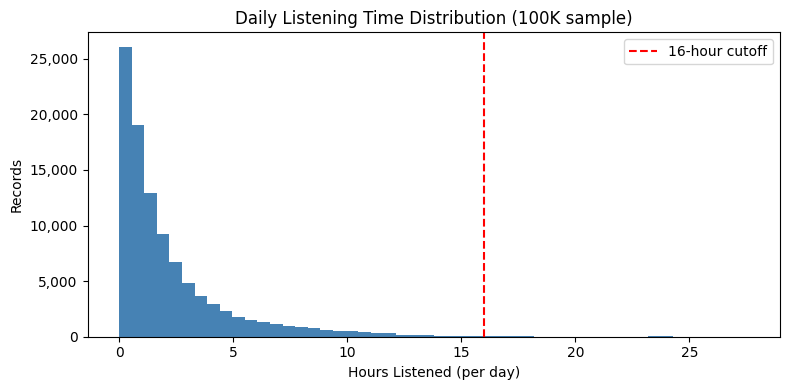

In [25]:
# Listening time distribution (sampled for performance)
listening_sample_df = run_query("""
SELECT total_secs / 3600 as hours
FROM kkbox.user_logs
WHERE total_secs >= 0 AND total_secs <= 100000
ORDER BY RAND()
LIMIT 100000
""")

plt.figure(figsize=(8, 4))
plt.hist(listening_sample_df['hours'], bins=50, color='steelblue', edgecolor='none')
plt.axvline(x=16, color='red', linestyle='--', label='16-hour cutoff')
plt.xlabel('Hours Listened (per day)')
plt.ylabel('Records')
plt.title('Daily Listening Time Distribution (100K sample)')
plt.legend()
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.tight_layout()
plt.show()

In [26]:
# Check duplicate user_logs on same date
run_query("""
SELECT 
    msno,
    date,
    COUNT(*) as records
FROM kkbox.user_logs
GROUP BY msno, date
HAVING COUNT(*) > 1
LIMIT 10
""")

,msno,date,records


No duplicate user-date combinations. Each record represents one user's listening activity for one day, so total_secs is daily listening time.

In [27]:
# Check for data quality issues in user_logs
run_query("""
SELECT 
    MIN(total_secs) as min_secs,
    MAX(total_secs) as max_secs,
    ROUND(AVG(total_secs), 0) as avg_secs
FROM kkbox.user_logs
""")

,min_secs,max_secs,avg_secs
0,-9.223372e+15,9.223372e+15,-1.444848e+12


Extreme values in total_secs: min and max are near ±9.2e15 (64-bit integer limits), indicating corrupt records. Need to quantify how many records are invalid.

In [28]:
# Identify invalid total_secs records
run_query("""
SELECT 
    CASE 
        WHEN total_secs < 0 THEN 'negative'
        WHEN total_secs > 86400 THEN 'over 24 hours'
        ELSE 'valid'
    END as category,
    COUNT(*) as record_count,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER(), 4) as pct
FROM kkbox.user_logs
GROUP BY category
ORDER BY record_count DESC
""")

,category,record_count,pct
0,valid,391902057,99.9478
1,over 24 hours,142993,0.0365
2,negative,61493,0.0157


99.95% of records fall between 0 and 86,400 seconds. But 24 hours of listening in a single day is still implausible. Need to examine the distribution to find a reasonable cutoff.

In [29]:
# Distribution of total_secs by hour ranges
run_query("""
SELECT 
    CASE 
        WHEN total_secs < 0 THEN 'negative'
        WHEN total_secs < 3600 THEN '0-1 hrs'
        WHEN total_secs < 7200 THEN '1-2 hrs'
        WHEN total_secs < 14400 THEN '2-4 hrs'
        WHEN total_secs < 28800 THEN '4-8 hrs'
        WHEN total_secs < 57600 THEN '8-16 hrs'
        WHEN total_secs < 86400 THEN '16-24 hrs'
        ELSE '24+ hrs'
    END as hours_range,
    COUNT(*) as record_count,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER(), 2) as pct
FROM kkbox.user_logs
GROUP BY hours_range
ORDER BY 
    CASE hours_range
        WHEN 'negative' THEN 0
        WHEN '0-1 hrs' THEN 1
        WHEN '1-2 hrs' THEN 2
        WHEN '2-4 hrs' THEN 3
        WHEN '4-8 hrs' THEN 4
        WHEN '8-16 hrs' THEN 5
        WHEN '16-24 hrs' THEN 6
        ELSE 7
    END
""")

,hours_range,record_count,pct
0,negative,61493,0.02
1,0-1 hrs,164676210,42.00
2,1-2 hrs,87547132,22.33
3,2-4 hrs,75017878,19.13
4,4-8 hrs,44701874,11.40
5,8-16 hrs,18796514,4.79
6,16-24 hrs,1162428,0.30
7,24+ hrs,143014,0.04


95% of records are under 8 hours, 99.7% under 16 hours. Records above 16 hours or negative will be excluded during feature engineering.

## Train User Coverage

How many of the prediction set users have data in each table?

In [30]:
# Check prediction set users data per table
run_query("""
WITH train_users AS (
    SELECT DISTINCT msno FROM kkbox.train
)
SELECT 
    'members' as table_name,
    COUNT(DISTINCT t.msno) as train_users_with_data,
    ROUND(COUNT(DISTINCT t.msno) * 100.0 / (SELECT COUNT(*) FROM train_users), 1) as pct
FROM train_users t
JOIN kkbox.members m ON t.msno = m.msno

UNION ALL

SELECT 
    'transactions',
    COUNT(DISTINCT t.msno),
    ROUND(COUNT(DISTINCT t.msno) * 100.0 / (SELECT COUNT(*) FROM train_users), 1)
FROM train_users t
JOIN kkbox.transactions tr ON t.msno = tr.msno

UNION ALL

SELECT 
    'user_logs',
    COUNT(DISTINCT t.msno),
    ROUND(COUNT(DISTINCT t.msno) * 100.0 / (SELECT COUNT(*) FROM train_users), 1)
FROM train_users t
JOIN kkbox.user_logs ul ON t.msno = ul.msno
""")

,table_name,train_users_with_data,pct
0,members,860967,88.7
1,transactions,933578,96.1
2,user_logs,850296,87.6


96.1% of train users have transaction records, 88.7% have member demographics, and 87.6% have listening logs. About 12% of the prediction set has no listening history in the data, which will need to be handled during feature engineering. The high transaction coverage makes sense since the churn label is based on subscription behavior.

## Summary

**Data quality issues to address:**
- Age (bd): 67% invalid (0 or negative). Treat values outside 1-100 as missing.
- Gender: 65% missing. Use as a categorical feature with "unknown" category.
- total_secs: 0.36% invalid (negative or >16 hours). Exclude these records.

**Coverage gaps:**
- 11% of train users have no member demographics
- 12% of train users have no listening logs

**Key dataset characteristics:**
- 970,960 users in prediction set, 9% churn rate
- Churn = failed to renew within 30 days of Feb 2017 expiration
- 392M listening records across 26 months
- 1.4M transactions across 27 months
- Monthly plans (30 days) dominate at 85%
- 76% of transactions have auto-renew enabled